# Part Two: Image Classification with Tensorflow & Python.

In Part One of this, we had a brief walkthrough of how a Neural Network classifies images of clothing. Here, we get into the code just to prove all that theory we talked about in part one. Let's code then!

### Install the Dataset

We will use the Tensorflow datasets API to download and install the Fashioon MNIST dataset.

In my case I already have the tensorflow datasets installed and so the output is as above.

### Import the Required Libraries

In [5]:
!pip install tensorflow

  Using cached https://files.pythonhosted.org/packages/e6/35/f187bdf23be87092bd0f1200d43d23076cee4d0dec109f195173fd3ebc79/mock-2.0.0-py2.py3-none-any.whl
  Stored in directory: C:\Users\Local_User\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast


  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='pypi.org', port=443): Read timed out. (read timeout=15)")': /simple/gast/


In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

# import tensorflow and tensorflow datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

#Import helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# for progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.13.1


### Import the Fashion MNIST data

In [8]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

From Part One, there was a split of the dataset to 60k examples for training and 10k fr testing. Keenly looking at the output above you can see the same figures appearing. When loading the dataset, a metadata is returned as well as the training dataset and test dataset.

Also recall that the images are 28 by 28 grayscale images and makeup arrays of 28 by 28 with pixel values ranging from 0 to 255.
The laabels are an array of integers ranging from 0 to 9 and correspond to a class of clothing an image represents.

In [9]:
#create a list of classes since they are not included in the dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

##### Let's check if the number of training and testing examples proves the above claim

In [10]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples

print("The training test has {}".format(num_train_examples) + " examples")
print("The test test has {}".format(num_test_examples) + " examples")

The training test has 60000 examples
The test test has 10000 examples


Awesome the claim checks out!

### Preprocess the Data

The pixel value in an image can range from 0 to 255. The numbers in this range won't work so well with the model.Hence the values need to be normalized to the range[0,1]. Enter the Normalization function which will be applied to each image in training and test datasets.

In [11]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /=255
    return images, labels

# apply the normalize function to the training and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)


Now we take a look at the preprocessed data

In [12]:
# Take an image and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28,28))

# plot the image
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

It's a little pixelated and one can't really make of it. Looks like a shirt but it could be a coat.
Let's fix that by displaying the class name below each image of the first 10 images in the training set.

In [13]:
plt.figure(figsize=(10,10))
i=0

for (image, label) in test_dataset.take(10):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
    
plt.show()

### Nice!!!



## Model Building

All this while we have been exploring and preprocessing the data. Verifying the data is in the correct format is essential for building and traing the Neural Network.

### Setup the Layers

A **layer** is the basic building block of a Neural Network. It extracts a representation from the data fed into it.

Deep learning consists of chaining together simple layers. Most layers have internal parameters which are adjusted("learn") during training

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), #flattening
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) #create probabilities an image is of a certain class
])

Let's go over the layers again as discussed in part One:


**input** *tf.keras.layers.Flatten* - Our Neural Network's layer takes a vector as input, therefore, the 28x28 image is converted into a one dimensional array of length 28x28 (784). The process of converting a 2-dimensional image into a vector is called flattening.


**hidden** *tf.keras.layers.Dense* - A densely connected layer of 128 neurons. Each neuron takes input from all 784 neurons in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.


**output** (second)*tf.keras.layers.Dense* - A 10-neuron softmax layer, with each neuron representing a class of clothing. As in the previous layer, each neuron takes input from the 128 neurons in the layer before it. Each neuron weights the input according to learned parameters, and then outputs a value in the range [0, 1], representing the **probability** that the image belongs to that class. The sum of all 10 neuron values is 1

### Compile the Model

In this step, three setting are added to the model;
1. Loss Function - an algorithm that checks how far the predicted value is from the true/desired value.

2. Optimizer - an algorithm that adjusts inner parameters in order to minimize loss.

3. Metrics - Monitors the training and testing steps.

In [16]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) #accuracy is the fractin of images correctly classified

### Train the Model

Define the iteration behavior for the train dataset:

1. Repeat forever by specifying dataset.repeat() (the epochs parameter described below limits how long we perform training).

2. The dataset.shuffle(60000) randomizes the order so our model cannot learn anything from the order of the examples. *Only applies to training dataset*


3. And dataset.batch(32) tells model.fit to use batches of 32 images and labels when updating the model variables.


In [18]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

To train the model we call the *model.fit* method

In [20]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5


 680/1875 [=========>....................] - ETA: 6:02:00 - loss: 2.3538 - acc: 0.03 - ETA: 2:01:10 - loss: 2.2294 - acc: 0.12 - ETA: 1:13:05 - loss: 2.0875 - acc: 0.20 - ETA: 52:24 - loss: 1.9698 - acc: 0.2946 - ETA: 40:56 - loss: 1.8842 - acc: 0.34 - ETA: 33:39 - loss: 1.8360 - acc: 0.36 - ETA: 28:35 - loss: 1.7361 - acc: 0.41 - ETA: 24:53 - loss: 1.6806 - acc: 0.42 - ETA: 22:02 - loss: 1.6444 - acc: 0.44 - ETA: 19:48 - loss: 1.5881 - acc: 0.47 - ETA: 17:59 - loss: 1.5408 - acc: 0.49 - ETA: 16:30 - loss: 1.4939 - acc: 0.51 - ETA: 15:15 - loss: 1.4495 - acc: 0.52 - ETA: 14:10 - loss: 1.4252 - acc: 0.53 - ETA: 13:14 - loss: 1.4080 - acc: 0.53 - ETA: 12:26 - loss: 1.3709 - acc: 0.54 - ETA: 11:43 - loss: 1.3446 - acc: 0.55 - ETA: 11:05 - loss: 1.3149 - acc: 0.56 - ETA: 10:15 - loss: 1.2765 - acc: 0.57 - ETA: 9:46 - loss: 1.2545 - acc: 0.5813 - ETA: 9:06 - loss: 1.2317 - acc: 0.590 - ETA: 8:44 - loss: 1.2040 - acc: 0.602 - ETA: 8:23 - loss: 1.1843 - acc: 0.609 - ETA: 7:54 - loss: 1.1741 -

1429/1875 [=====================>........] - ETA: 40s - loss: 0.5977 - acc: 0.79 - ETA: 40s - loss: 0.5976 - acc: 0.79 - ETA: 40s - loss: 0.5969 - acc: 0.79 - ETA: 40s - loss: 0.5964 - acc: 0.79 - ETA: 39s - loss: 0.5958 - acc: 0.79 - ETA: 39s - loss: 0.5948 - acc: 0.79 - ETA: 39s - loss: 0.5947 - acc: 0.79 - ETA: 39s - loss: 0.5938 - acc: 0.79 - ETA: 38s - loss: 0.5930 - acc: 0.79 - ETA: 38s - loss: 0.5919 - acc: 0.79 - ETA: 38s - loss: 0.5906 - acc: 0.79 - ETA: 38s - loss: 0.5895 - acc: 0.79 - ETA: 37s - loss: 0.5888 - acc: 0.79 - ETA: 37s - loss: 0.5890 - acc: 0.79 - ETA: 37s - loss: 0.5880 - acc: 0.79 - ETA: 37s - loss: 0.5869 - acc: 0.79 - ETA: 36s - loss: 0.5860 - acc: 0.79 - ETA: 36s - loss: 0.5856 - acc: 0.79 - ETA: 36s - loss: 0.5851 - acc: 0.79 - ETA: 36s - loss: 0.5845 - acc: 0.79 - ETA: 35s - loss: 0.5841 - acc: 0.79 - ETA: 35s - loss: 0.5841 - acc: 0.79 - ETA: 35s - loss: 0.5840 - acc: 0.79 - ETA: 35s - loss: 0.5846 - acc: 0.79 - ETA: 35s - loss: 0.5840 - acc: 0.79 - ETA: 

1875/1875 [==============================] - ETA: 11s - loss: 0.5185 - acc: 0.81 - ETA: 11s - loss: 0.5179 - acc: 0.81 - ETA: 10s - loss: 0.5177 - acc: 0.81 - ETA: 10s - loss: 0.5172 - acc: 0.81 - ETA: 10s - loss: 0.5170 - acc: 0.81 - ETA: 10s - loss: 0.5167 - acc: 0.82 - ETA: 10s - loss: 0.5167 - acc: 0.82 - ETA: 10s - loss: 0.5164 - acc: 0.82 - ETA: 10s - loss: 0.5157 - acc: 0.82 - ETA: 10s - loss: 0.5154 - acc: 0.82 - ETA: 10s - loss: 0.5150 - acc: 0.82 - ETA: 9s - loss: 0.5148 - acc: 0.8208 - ETA: 9s - loss: 0.5143 - acc: 0.821 - ETA: 9s - loss: 0.5139 - acc: 0.821 - ETA: 9s - loss: 0.5134 - acc: 0.821 - ETA: 9s - loss: 0.5131 - acc: 0.821 - ETA: 9s - loss: 0.5130 - acc: 0.821 - ETA: 9s - loss: 0.5126 - acc: 0.821 - ETA: 9s - loss: 0.5125 - acc: 0.821 - ETA: 9s - loss: 0.5119 - acc: 0.821 - ETA: 9s - loss: 0.5116 - acc: 0.821 - ETA: 9s - loss: 0.5113 - acc: 0.821 - ETA: 8s - loss: 0.5114 - acc: 0.821 - ETA: 8s - loss: 0.5112 - acc: 0.821 - ETA: 8s - loss: 0.5108 - acc: 0.822 - ETA:

 795/1875 [===========>..................] - ETA: 5:09 - loss: 0.2389 - acc: 0.906 - ETA: 1:41 - loss: 0.3116 - acc: 0.890 - ETA: 1:14 - loss: 0.3543 - acc: 0.875 - ETA: 1:01 - loss: 0.3528 - acc: 0.865 - ETA: 51s - loss: 0.3615 - acc: 0.859 - ETA: 45s - loss: 0.3683 - acc: 0.85 - ETA: 42s - loss: 0.3842 - acc: 0.85 - ETA: 40s - loss: 0.3750 - acc: 0.86 - ETA: 38s - loss: 0.3885 - acc: 0.85 - ETA: 38s - loss: 0.3847 - acc: 0.86 - ETA: 39s - loss: 0.3873 - acc: 0.86 - ETA: 38s - loss: 0.3906 - acc: 0.85 - ETA: 38s - loss: 0.3933 - acc: 0.85 - ETA: 37s - loss: 0.3888 - acc: 0.85 - ETA: 36s - loss: 0.3987 - acc: 0.85 - ETA: 35s - loss: 0.3985 - acc: 0.85 - ETA: 34s - loss: 0.4012 - acc: 0.85 - ETA: 34s - loss: 0.3988 - acc: 0.85 - ETA: 34s - loss: 0.4016 - acc: 0.85 - ETA: 34s - loss: 0.4018 - acc: 0.85 - ETA: 33s - loss: 0.3992 - acc: 0.85 - ETA: 33s - loss: 0.4076 - acc: 0.85 - ETA: 32s - loss: 0.4058 - acc: 0.85 - ETA: 32s - loss: 0.4042 - acc: 0.85 - ETA: 32s - loss: 0.4016 - acc: 0.8

1535/1875 [=======================>......] - ETA: 16s - loss: 0.3844 - acc: 0.86 - ETA: 16s - loss: 0.3848 - acc: 0.86 - ETA: 16s - loss: 0.3845 - acc: 0.86 - ETA: 16s - loss: 0.3840 - acc: 0.86 - ETA: 16s - loss: 0.3839 - acc: 0.86 - ETA: 16s - loss: 0.3839 - acc: 0.86 - ETA: 16s - loss: 0.3834 - acc: 0.86 - ETA: 16s - loss: 0.3831 - acc: 0.86 - ETA: 16s - loss: 0.3832 - acc: 0.86 - ETA: 16s - loss: 0.3826 - acc: 0.86 - ETA: 16s - loss: 0.3823 - acc: 0.86 - ETA: 16s - loss: 0.3829 - acc: 0.86 - ETA: 16s - loss: 0.3824 - acc: 0.86 - ETA: 16s - loss: 0.3823 - acc: 0.86 - ETA: 16s - loss: 0.3822 - acc: 0.86 - ETA: 16s - loss: 0.3820 - acc: 0.86 - ETA: 16s - loss: 0.3816 - acc: 0.86 - ETA: 16s - loss: 0.3812 - acc: 0.86 - ETA: 15s - loss: 0.3819 - acc: 0.86 - ETA: 15s - loss: 0.3826 - acc: 0.86 - ETA: 15s - loss: 0.3826 - acc: 0.86 - ETA: 15s - loss: 0.3831 - acc: 0.86 - ETA: 15s - loss: 0.3830 - acc: 0.86 - ETA: 15s - loss: 0.3832 - acc: 0.86 - ETA: 15s - loss: 0.3829 - acc: 0.86 - ETA: 

1875/1875 [==============================] - ETA: 5s - loss: 0.3764 - acc: 0.863 - ETA: 5s - loss: 0.3763 - acc: 0.863 - ETA: 5s - loss: 0.3762 - acc: 0.863 - ETA: 5s - loss: 0.3760 - acc: 0.863 - ETA: 5s - loss: 0.3760 - acc: 0.863 - ETA: 5s - loss: 0.3759 - acc: 0.863 - ETA: 5s - loss: 0.3759 - acc: 0.863 - ETA: 5s - loss: 0.3757 - acc: 0.863 - ETA: 5s - loss: 0.3756 - acc: 0.863 - ETA: 4s - loss: 0.3755 - acc: 0.864 - ETA: 4s - loss: 0.3753 - acc: 0.864 - ETA: 4s - loss: 0.3755 - acc: 0.864 - ETA: 4s - loss: 0.3756 - acc: 0.863 - ETA: 4s - loss: 0.3756 - acc: 0.864 - ETA: 4s - loss: 0.3754 - acc: 0.864 - ETA: 4s - loss: 0.3752 - acc: 0.864 - ETA: 4s - loss: 0.3750 - acc: 0.864 - ETA: 4s - loss: 0.3749 - acc: 0.864 - ETA: 4s - loss: 0.3747 - acc: 0.864 - ETA: 4s - loss: 0.3747 - acc: 0.864 - ETA: 4s - loss: 0.3746 - acc: 0.864 - ETA: 4s - loss: 0.3745 - acc: 0.864 - ETA: 4s - loss: 0.3744 - acc: 0.864 - ETA: 4s - loss: 0.3741 - acc: 0.864 - ETA: 4s - loss: 0.3740 - acc: 0.864 - ETA: 

 788/1875 [===========>..................] - ETA: 5:29 - loss: 0.2947 - acc: 0.875 - ETA: 1:47 - loss: 0.4440 - acc: 0.828 - ETA: 1:15 - loss: 0.4404 - acc: 0.830 - ETA: 58s - loss: 0.4144 - acc: 0.835 - ETA: 54s - loss: 0.4018 - acc: 0.84 - ETA: 48s - loss: 0.4153 - acc: 0.84 - ETA: 44s - loss: 0.3967 - acc: 0.85 - ETA: 43s - loss: 0.3905 - acc: 0.85 - ETA: 42s - loss: 0.3872 - acc: 0.85 - ETA: 41s - loss: 0.3894 - acc: 0.85 - ETA: 40s - loss: 0.4079 - acc: 0.85 - ETA: 39s - loss: 0.4152 - acc: 0.84 - ETA: 38s - loss: 0.4184 - acc: 0.85 - ETA: 38s - loss: 0.4109 - acc: 0.85 - ETA: 38s - loss: 0.4010 - acc: 0.85 - ETA: 38s - loss: 0.3957 - acc: 0.85 - ETA: 37s - loss: 0.3976 - acc: 0.85 - ETA: 36s - loss: 0.3906 - acc: 0.85 - ETA: 36s - loss: 0.3843 - acc: 0.86 - ETA: 36s - loss: 0.3787 - acc: 0.86 - ETA: 36s - loss: 0.3753 - acc: 0.86 - ETA: 37s - loss: 0.3757 - acc: 0.86 - ETA: 37s - loss: 0.3735 - acc: 0.86 - ETA: 37s - loss: 0.3708 - acc: 0.86 - ETA: 36s - loss: 0.3706 - acc: 0.86 

1552/1875 [=======================>......] - ETA: 17s - loss: 0.3435 - acc: 0.87 - ETA: 17s - loss: 0.3434 - acc: 0.87 - ETA: 17s - loss: 0.3436 - acc: 0.87 - ETA: 17s - loss: 0.3434 - acc: 0.87 - ETA: 17s - loss: 0.3438 - acc: 0.87 - ETA: 17s - loss: 0.3439 - acc: 0.87 - ETA: 17s - loss: 0.3440 - acc: 0.87 - ETA: 17s - loss: 0.3434 - acc: 0.87 - ETA: 17s - loss: 0.3430 - acc: 0.87 - ETA: 16s - loss: 0.3431 - acc: 0.87 - ETA: 16s - loss: 0.3429 - acc: 0.87 - ETA: 16s - loss: 0.3431 - acc: 0.87 - ETA: 16s - loss: 0.3434 - acc: 0.87 - ETA: 16s - loss: 0.3433 - acc: 0.87 - ETA: 16s - loss: 0.3434 - acc: 0.87 - ETA: 16s - loss: 0.3429 - acc: 0.87 - ETA: 16s - loss: 0.3426 - acc: 0.87 - ETA: 16s - loss: 0.3423 - acc: 0.87 - ETA: 16s - loss: 0.3418 - acc: 0.87 - ETA: 16s - loss: 0.3419 - acc: 0.87 - ETA: 16s - loss: 0.3417 - acc: 0.87 - ETA: 16s - loss: 0.3421 - acc: 0.87 - ETA: 16s - loss: 0.3419 - acc: 0.87 - ETA: 16s - loss: 0.3418 - acc: 0.87 - ETA: 16s - loss: 0.3418 - acc: 0.87 - ETA: 

1875/1875 [==============================] - ETA: 5s - loss: 0.3384 - acc: 0.877 - ETA: 5s - loss: 0.3384 - acc: 0.877 - ETA: 5s - loss: 0.3386 - acc: 0.877 - ETA: 5s - loss: 0.3391 - acc: 0.877 - ETA: 4s - loss: 0.3390 - acc: 0.877 - ETA: 4s - loss: 0.3389 - acc: 0.877 - ETA: 4s - loss: 0.3387 - acc: 0.877 - ETA: 4s - loss: 0.3385 - acc: 0.877 - ETA: 4s - loss: 0.3386 - acc: 0.877 - ETA: 4s - loss: 0.3386 - acc: 0.877 - ETA: 4s - loss: 0.3384 - acc: 0.877 - ETA: 4s - loss: 0.3386 - acc: 0.877 - ETA: 4s - loss: 0.3385 - acc: 0.877 - ETA: 4s - loss: 0.3382 - acc: 0.877 - ETA: 4s - loss: 0.3383 - acc: 0.877 - ETA: 4s - loss: 0.3384 - acc: 0.877 - ETA: 4s - loss: 0.3384 - acc: 0.877 - ETA: 4s - loss: 0.3385 - acc: 0.877 - ETA: 4s - loss: 0.3383 - acc: 0.877 - ETA: 4s - loss: 0.3381 - acc: 0.877 - ETA: 4s - loss: 0.3380 - acc: 0.877 - ETA: 4s - loss: 0.3378 - acc: 0.878 - ETA: 4s - loss: 0.3380 - acc: 0.877 - ETA: 3s - loss: 0.3379 - acc: 0.877 - ETA: 3s - loss: 0.3379 - acc: 0.877 - ETA: 

 927/1875 [=============>................] - ETA: 4:25 - loss: 0.3425 - acc: 0.906 - ETA: 1:14 - loss: 0.2808 - acc: 0.900 - ETA: 51s - loss: 0.3543 - acc: 0.878 - ETA: 43s - loss: 0.3595 - acc: 0.86 - ETA: 39s - loss: 0.3575 - acc: 0.86 - ETA: 37s - loss: 0.3515 - acc: 0.86 - ETA: 35s - loss: 0.3393 - acc: 0.87 - ETA: 35s - loss: 0.3395 - acc: 0.87 - ETA: 33s - loss: 0.3309 - acc: 0.87 - ETA: 32s - loss: 0.3318 - acc: 0.87 - ETA: 31s - loss: 0.3293 - acc: 0.87 - ETA: 31s - loss: 0.3310 - acc: 0.87 - ETA: 30s - loss: 0.3293 - acc: 0.87 - ETA: 29s - loss: 0.3311 - acc: 0.87 - ETA: 30s - loss: 0.3311 - acc: 0.87 - ETA: 29s - loss: 0.3254 - acc: 0.88 - ETA: 29s - loss: 0.3313 - acc: 0.87 - ETA: 28s - loss: 0.3250 - acc: 0.88 - ETA: 28s - loss: 0.3239 - acc: 0.88 - ETA: 28s - loss: 0.3189 - acc: 0.88 - ETA: 28s - loss: 0.3162 - acc: 0.88 - ETA: 28s - loss: 0.3204 - acc: 0.88 - ETA: 27s - loss: 0.3198 - acc: 0.88 - ETA: 27s - loss: 0.3164 - acc: 0.88 - ETA: 27s - loss: 0.3151 - acc: 0.88 - 

1875/1875 [==============================] - ETA: 12s - loss: 0.3158 - acc: 0.88 - ETA: 12s - loss: 0.3155 - acc: 0.88 - ETA: 12s - loss: 0.3156 - acc: 0.88 - ETA: 12s - loss: 0.3162 - acc: 0.88 - ETA: 12s - loss: 0.3168 - acc: 0.88 - ETA: 12s - loss: 0.3170 - acc: 0.88 - ETA: 11s - loss: 0.3177 - acc: 0.88 - ETA: 11s - loss: 0.3181 - acc: 0.88 - ETA: 11s - loss: 0.3181 - acc: 0.88 - ETA: 11s - loss: 0.3181 - acc: 0.88 - ETA: 11s - loss: 0.3181 - acc: 0.88 - ETA: 11s - loss: 0.3185 - acc: 0.88 - ETA: 11s - loss: 0.3190 - acc: 0.88 - ETA: 11s - loss: 0.3190 - acc: 0.88 - ETA: 11s - loss: 0.3195 - acc: 0.88 - ETA: 11s - loss: 0.3193 - acc: 0.88 - ETA: 11s - loss: 0.3192 - acc: 0.88 - ETA: 11s - loss: 0.3191 - acc: 0.88 - ETA: 11s - loss: 0.3193 - acc: 0.88 - ETA: 11s - loss: 0.3196 - acc: 0.88 - ETA: 11s - loss: 0.3200 - acc: 0.88 - ETA: 10s - loss: 0.3197 - acc: 0.88 - ETA: 10s - loss: 0.3203 - acc: 0.88 - ETA: 10s - loss: 0.3202 - acc: 0.88 - ETA: 10s - loss: 0.3204 - acc: 0.88 - ETA: 

 958/1875 [==============>...............] - ETA: 3:57 - loss: 0.3108 - acc: 0.906 - ETA: 58s - loss: 0.3134 - acc: 0.890 - ETA: 41s - loss: 0.2743 - acc: 0.90 - ETA: 35s - loss: 0.3036 - acc: 0.89 - ETA: 32s - loss: 0.3472 - acc: 0.87 - ETA: 30s - loss: 0.3466 - acc: 0.87 - ETA: 29s - loss: 0.3408 - acc: 0.87 - ETA: 27s - loss: 0.3354 - acc: 0.87 - ETA: 27s - loss: 0.3338 - acc: 0.87 - ETA: 26s - loss: 0.3407 - acc: 0.87 - ETA: 25s - loss: 0.3323 - acc: 0.87 - ETA: 25s - loss: 0.3293 - acc: 0.87 - ETA: 25s - loss: 0.3260 - acc: 0.87 - ETA: 24s - loss: 0.3251 - acc: 0.87 - ETA: 24s - loss: 0.3221 - acc: 0.87 - ETA: 24s - loss: 0.3215 - acc: 0.88 - ETA: 24s - loss: 0.3264 - acc: 0.87 - ETA: 23s - loss: 0.3257 - acc: 0.87 - ETA: 23s - loss: 0.3248 - acc: 0.87 - ETA: 23s - loss: 0.3235 - acc: 0.88 - ETA: 23s - loss: 0.3213 - acc: 0.87 - ETA: 23s - loss: 0.3201 - acc: 0.87 - ETA: 22s - loss: 0.3202 - acc: 0.87 - ETA: 22s - loss: 0.3170 - acc: 0.88 - ETA: 22s - loss: 0.3166 - acc: 0.88 - ET

1875/1875 [==============================] - ETA: 11s - loss: 0.3052 - acc: 0.88 - ETA: 11s - loss: 0.3048 - acc: 0.88 - ETA: 11s - loss: 0.3049 - acc: 0.88 - ETA: 11s - loss: 0.3045 - acc: 0.88 - ETA: 11s - loss: 0.3043 - acc: 0.88 - ETA: 11s - loss: 0.3043 - acc: 0.88 - ETA: 11s - loss: 0.3043 - acc: 0.88 - ETA: 11s - loss: 0.3042 - acc: 0.88 - ETA: 11s - loss: 0.3044 - acc: 0.88 - ETA: 10s - loss: 0.3045 - acc: 0.88 - ETA: 10s - loss: 0.3043 - acc: 0.88 - ETA: 10s - loss: 0.3042 - acc: 0.88 - ETA: 10s - loss: 0.3043 - acc: 0.88 - ETA: 10s - loss: 0.3039 - acc: 0.88 - ETA: 10s - loss: 0.3042 - acc: 0.88 - ETA: 10s - loss: 0.3044 - acc: 0.88 - ETA: 10s - loss: 0.3039 - acc: 0.88 - ETA: 10s - loss: 0.3036 - acc: 0.88 - ETA: 10s - loss: 0.3036 - acc: 0.88 - ETA: 10s - loss: 0.3037 - acc: 0.88 - ETA: 10s - loss: 0.3034 - acc: 0.88 - ETA: 10s - loss: 0.3033 - acc: 0.88 - ETA: 10s - loss: 0.3035 - acc: 0.88 - ETA: 10s - loss: 0.3034 - acc: 0.88 - ETA: 10s - loss: 0.3035 - acc: 0.88 - ETA: 

### Track How Accuracy Improves After Each Epoch

if you scroll through the above output you will be able to see how the accuracy of our model improves with each epoch. From the first epoch's 0.8271(82.71%) accuracy to the fifth & last epoch's 0.8890(88.9%)  accuracy. 
Epochs are the number of iterations the model trains on a one example. This model achieves an accuracy off 88.9% which is quite good for this classification problem.

### Evaluate the Accuracy

Let's apply this model on the test data to evaluate how accurate it is.

In [23]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))


313/313 [==============================] - ETA: 22s - loss: 0.3846 - acc: 0.90 - ETA: 6s - loss: 0.3023 - acc: 0.8854 - ETA: 5s - loss: 0.3173 - acc: 0.875 - ETA: 4s - loss: 0.3003 - acc: 0.872 - ETA: 4s - loss: 0.2874 - acc: 0.875 - ETA: 4s - loss: 0.3219 - acc: 0.862 - ETA: 3s - loss: 0.3383 - acc: 0.856 - ETA: 3s - loss: 0.3515 - acc: 0.848 - ETA: 3s - loss: 0.3390 - acc: 0.856 - ETA: 3s - loss: 0.3360 - acc: 0.861 - ETA: 3s - loss: 0.3411 - acc: 0.859 - ETA: 3s - loss: 0.3478 - acc: 0.860 - ETA: 3s - loss: 0.3464 - acc: 0.864 - ETA: 2s - loss: 0.3433 - acc: 0.865 - ETA: 2s - loss: 0.3400 - acc: 0.868 - ETA: 2s - loss: 0.3429 - acc: 0.868 - ETA: 2s - loss: 0.3406 - acc: 0.868 - ETA: 2s - loss: 0.3384 - acc: 0.868 - ETA: 2s - loss: 0.3418 - acc: 0.869 - ETA: 2s - loss: 0.3439 - acc: 0.869 - ETA: 2s - loss: 0.3401 - acc: 0.870 - ETA: 2s - loss: 0.3384 - acc: 0.870 - ETA: 2s - loss: 0.3400 - acc: 0.870 - ETA: 2s - loss: 0.3430 - acc: 0.869 - ETA: 2s - loss: 0.3447 - acc: 0.869 - ETA: 1

In [24]:
print('Accuracy on test dataset:', test_accuracy)

Accuracy on test dataset: 0.874


The accuracy on the test dataset is lower than the accuracy on the training dataset. This is expected,especially, since the model was trained on the train_dataset. When the model sees images it has never seen during training, (that is, from the test_dataset), we can expect performance to go down.

## Let's Predict!

In [25]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [26]:
predictions.shape

(32, 10)

And that's it! The model has predicted the label for each image in the test dataset. Let's explore

In [28]:
predictions[0] #first prediction

array([1.8083496e-05, 1.7692341e-07, 3.1754937e-02, 8.3476603e-05,
       1.6435248e-01, 1.1334535e-06, 8.0376887e-01, 1.3233492e-08,
       2.0834928e-05, 2.3672428e-08], dtype=float32)

A prediction is an array of 10 numbers that describe the "confidence" of the model that the image corresponds to each of the 10 different classes/labels of clothing. 

Let's simplify the prediction output by checking which label has the highest confidence value:

In [29]:
np.argmax(predictions[0])

6

Recall our **class_names** list. Let's find out which class is represented by 6.

In [30]:
class_names[6]

'Shirt'

Hmm! So our model is most confident that the image is a shirt. Let's check with the test label to see if this is correct;

In [31]:
test_labels[0]

6

So it is correct after all!

Let's graph this to look at the fullset of 10 channels

In [32]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Now let's look at the 0th image we have predicted above (seeing is believing, sort of):

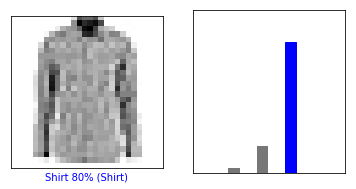

In [33]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

And there you have it! A shirt indeed.

Let's try another random prediction...

In [36]:
i = 9
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

This is a tricky one! Personally I see a "long" t-shirt but I could be wrong. The model classifies it as a dress. Let's try another!!

In [37]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

Aaah! Finally, that's what a t-shirt looks like. The model has this one spot on!

Let's do several of these and see how it turns out!

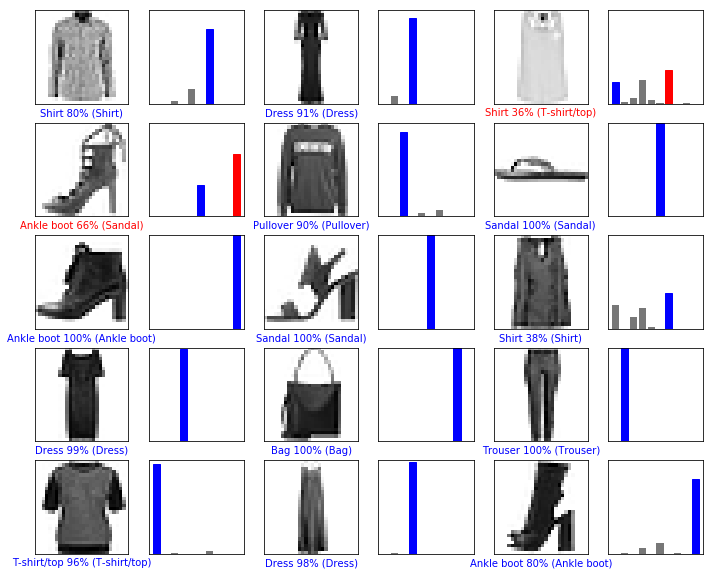

In [38]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

The model performs generally well. 

Let's do a prediction on an image

In [45]:
# Pick an image from the test dataset
img = test_images[12]

print(img.shape)

(28, 28, 1)


In [46]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [47]:
#Predict!!!
predictions_single = model.predict(img)

print(predictions_single)

[[9.55040514e-01 1.02591940e-07 9.58003290e-03 5.95918827e-05
  1.13835486e-04 2.41793696e-09 3.51812579e-02 1.63180992e-13
  2.47550834e-05 1.39397272e-10]]


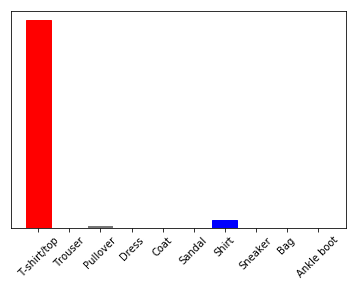

In [48]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [49]:
np.argmax(predictions_single[0])


0

In [50]:
class_names[0]

'T-shirt/top'